This notebook compares the performance of different distributed estimation schemes :<br>
- KCF (Kalman Consensus Filter, 2007)<br>
- KCF with Weighted Consensus (KCF-WDG, 2019)<br>

In [1]:
import os
import settings.input

# Choose target and sensor-network
input_files = []
input_files.append(os.path.join("settings","json_files", "target-rotating.json"))
input_files.append(os.path.join("settings","json_files", "graph-chain.json"))

# Read input files
input_data = settings.input.read(input_files)

Consider a network of sensors connected as,

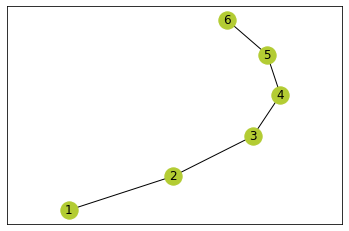

In [2]:
from sim.helpers import show_graph
show_graph(input_data["network"]["adjacency"])

Consider the scenario where sensors `4`, `5` and `6` have high estimation error; We expect this to cause poor performance at sensor `3`, in the case of distributed estimation schemes that do not weight their neighbors' information (such as the Kalman Consensus Filter).

In [3]:
big_number = 100000
input_data["network"]["noise_covariances"]["4"] = [[big_number, 0], [0, big_number]]
input_data["network"]["noise_covariances"]["5"] = [[big_number, 0], [0, big_number]]
input_data["network"]["noise_covariances"]["6"] = [[big_number, 0], [0, big_number]]

In the following simulation, the sensor network observes a target in a circular trajectory (in presense of significant system noise). <br>
We compare the performance of KCF & KCF-WDG :

Initializing a sensor network with KCF (2009) scheme...
Warning, the scheme KCF-WDG is not fully distributed.
Initializing a sensor network with KCF-WDG scheme...
Simulating for 150 time-steps...
Done. 
 ---------------------------- 
KCF Scheme (Poor performance) : 
Plotted history of target coordinates.
Plotted history of sensor 3's estimates.


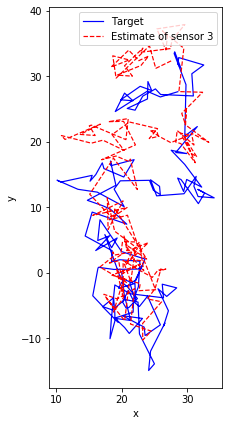

Optimal KCF-WDG Scheme (Better performance) : 
Plotted history of target coordinates.
Plotted history of sensor 3's estimates.


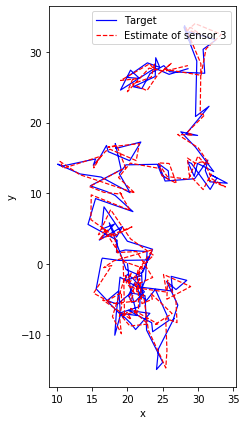

In [10]:
from sim.simulation import simulate_many
sensor_initials = {"estimate_prior": [[20], [0]],
                   "ErrCov_prior": [[100,0],[0,100]]}

results = simulate_many(input_data, duration = 150, est_schemes=["KCF", "KCF-WDG"], 
                        sensor_initials=sensor_initials)
print("KCF Scheme (Poor performance) : ")
results[0].plot_xy(target=True, estimates_of="3")
print("Optimal KCF-WDG Scheme (Better performance) : ")
results[1].plot_xy(target=True, estimates_of="3")

Estimated Error Covariance of sensor 3, using KCF :


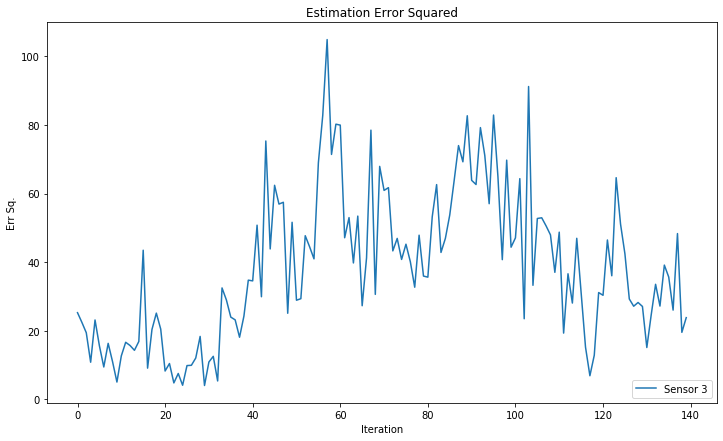

Estimated Error Covariance of sensor 3, using KCF-WC :


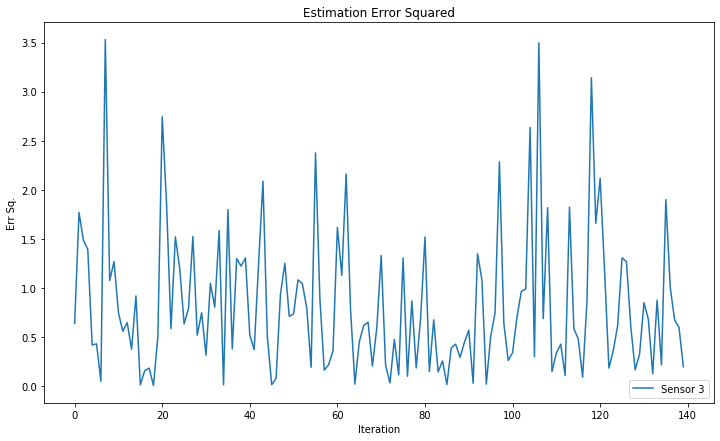

In [11]:
##### Estimation Error (e^T . e)
print("Estimated Error Covariance of sensor 3, using KCF :")
results[0].plot_error_sq(err_of="3")
print("Estimated Error Covariance of sensor 3, using KCF-WC :")
results[1].plot_error_sq(err_of="3")

Estimated Error Covariance of sensor 3, using KCF :


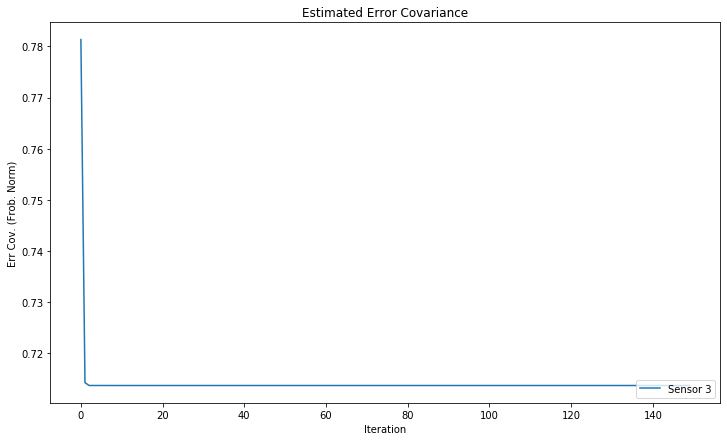

Estimated Error Covariance of sensor 3, using KCF-WC :


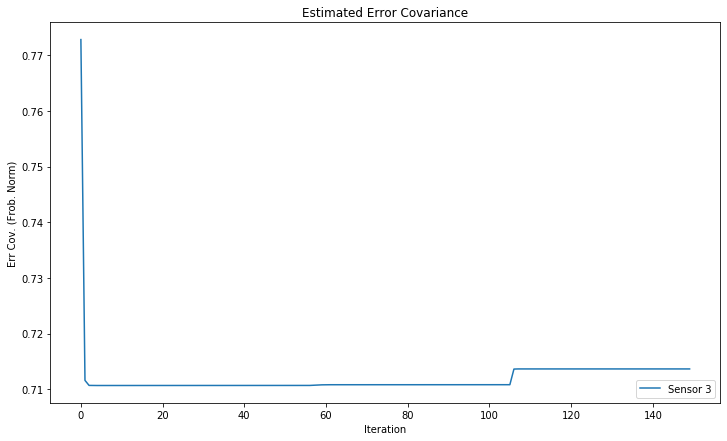

In [12]:
##### Estimated Error Covariance
print("Estimated Error Covariance of sensor 3, using KCF :")
results[0].plot_ErrCov(ErrCov_of="3")
print("Estimated Error Covariance of sensor 3, using KCF-WC :")
results[1].plot_ErrCov(ErrCov_of="3")

Since the sensor network operates via its own classobjects, we can simulate two estimation schemes concurrently and compare their performances. <br>
To simulate a single estimation scheme, use `sim.simulation.simulate`.